# Load Libraries

In [2]:
# numpy and pandas
import numpy as np
import pandas as pd
import math

# Generic
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import clear_output
import pickle

# Images
from PIL import Image
from skimage.transform import resize
import cv2
# import talos as ta

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, roc_curve
from sklearn.utils import class_weight


# Tensorflow
import tensorflow as tf
# import tensorflow.compat.v1 as tf

# Keras
from keras.layers import Input, Dense, Dropout, BatchNormalization, concatenate
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD 
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau, Callback, LearningRateScheduler
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras import metrics
from keras import Sequential


# Global Parameters

In [3]:
perc_split = [0.7, 0.15, 0.15]
input_shape = (224, 224, 3)
seed = 14
os.environ["CUDA_VISIBLE_DEVICES"]="0"




# Load Classes and Functions

In [4]:
# chexNet weights
# https://github.com/brucechou1983/CheXNet-Keras
chexnet_weights = '/home/iexpress/TCGA/weights/best_weights.h5'

def chexnet_preprocess_input(value):
    return preprocess_input(value)


def get_chexnet_model():
    input_shape = (224, 224, 3)
    img_input = Input(shape=input_shape)
    base_weights = 'imagenet'

    # create the base pre-trained model
    base_model = DenseNet121(
        include_top=False,
        input_tensor=img_input,
        input_shape=input_shape,
        weights=base_weights,
        pooling='avg'
    )

    x = base_model.output
    # add a logistic layer -- let's say we have 14 classes
    predictions = Dense(
        14,
        activation='sigmoid',
        name='predictions')(x)

    # this is the model we will use
    model = Model(
        inputs=img_input,
        outputs=predictions,
    )

    # load chexnet weights
    model.load_weights(chexnet_weights)

    # return model
    return base_model, model

In [60]:
### funciones

def get_class_weight(csv_file_path, target_class):
    df = pd.read_csv(csv_file_path, sep=';')
    total_counts = df.shape[0]
    class_weight = []

    ratio_pos = df.loc[(df[target_class] == 'Y')].shape[0] / total_counts
    ratio_neg = df.loc[(df[target_class] == 'N')].shape[0] / total_counts
    class_weight = np.array((ratio_pos, ratio_neg))
        
    return class_weight

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
# def auc(y_true, y_pred):
#     # any tensorflow metric
#     value, update_op = tf.metrics.auc(y_true, y_pred)

#     # find all variables created for this metric
#     metric_vars = [i for i in tf.local_variables() if 'auc' in i.name.split('/')[1]]

#     # Add metric variables to GLOBAL_VARIABLES collection.
#     # They will be initialized for new session.
#     for v in metric_vars:
#         tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

#     # force to update metric values
#     with tf.control_dependencies([update_op]):
#         value = tf.identity(value)
#     return value



def get_mlp(dim):
    
    # define our MLP network
    model = Sequential()
    model.add(Dense(256, input_dim=dim, activation="relu"))
    model.add(Dense(128, input_dim=dim, activation="relu"))

    # return our model
    return model

def get_cnn():
    # get base model, model
    base_model, chexnet_model = get_chexnet_model()
    # print a model summary
    # base_model.summary()

    x = base_model.output
    
    x = BatchNormalization()(x)
    
    
    # Dropout layer
    # x = Dropout(0.5)(x)
    # one more layer (relu)
    x = Dense(256, 
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l1_l2(0.1, 0.001))(x)
    x = BatchNormalization()(x)
    
       # Dropout layer
    # x = Dropout(0.5)(x)
    # one more layer (relu)
    x = Dense(128, 
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l1_l2(0.1, 0.001))(x)
    x = BatchNormalization()(x)
    
       # Dropout layer
    # x = Dropout(0.5)(x)
    # one more layer (relu)
    x = Dense(64, 
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l1_l2(0.1, 0.001))(x)
    x = BatchNormalization()(x)
    
       # Dropout layer
    # x = Dropout(0.5)(x)
    # one more layer (relu)
    x = Dense(32, 
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l1_l2(0.1, 0.001))(x)
    x = BatchNormalization()(x)   
   
    
    # x = Dense(256, activation='relu')(x)
    # x = Dense(128, activation='relu')(x)
    # x = Dense(64, activation='relu')(x)
    # x = Dense(32, activation='relu')(x)
    # Dropout layer
    #x = Dropout(0.2)(x)
    
    # Dropout layer
    x = Dropout(0.5)(x)
    # add a logistic layer -- let's say we have 6 classes

    # this is the model we will use
    model = Model(
        inputs=base_model.input,
        outputs=x,
    )

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all base_model layers
    for layer in base_model.layers:
        layer.trainable = True

    
    return model


def get_mixed_model(dim):
    # create the MLP and CNN models
    mlp = get_mlp(dim)
    cnn = get_cnn()
    
    # create the input to our final set of layers as the *output* of both
    # the MLP and CNN
    combinedInput = concatenate([mlp.output, cnn.output])
    
    # our final FC layer head will have two dense layers, the final one
    # being our regression head
    x = Dense(256, activation="relu")(combinedInput)
    predictions = Dense(
        1,
        activation='sigmoid')(x)
    
    # our final model will accept categorical/numerical data on the MLP
    # input and images on the CNN input, outputting a single value (the
    # predicted price of the house)
    model = Model(inputs=[mlp.input, cnn.input], outputs=predictions)
    
    return model
    



In [61]:
def grafica_entrenamiento(tr_auc, val_auc, tr_loss, val_loss, best_i,
                          figsize=(10,5), path_results = None):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_loss)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_loss)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=12)
    plt.xlabel('época', fontsize=18)        
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.subplot(1,2,2)
    
    plt.plot(1+np.arange(len(tr_auc)),  np.array(tr_auc))
    plt.plot(1+np.arange(len(val_auc)), np.array(val_auc))
    plt.plot(1+best_i, val_auc[best_i], 'or')
    plt.title('AUC', fontsize=18)
    plt.ylabel('AUC', fontsize=12)
    plt.xlabel('época', fontsize=18)    
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    if (path_results != None):
        plt.savefig(os.path.join(path_results, 'auc_loss.png'))
    plt.show()
    
class TrainingPlot(Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.auc = []
        self.val_losses = []
        self.val_auc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):       
       
        
        # Before plotting ensure at least 10 epochs have passed
        if epoch > 2:
             # Append the logs, losses and accuracies to the lists
            self.logs.append(logs)        
            self.auc.append(logs.get('auc'))        
            self.val_auc.append(logs.get('val_auc'))
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            best_i = np.argmax(self.val_auc)
            grafica_entrenamiento(self.auc, self.val_auc, self.losses, self.val_losses, best_i)

plot_losses = TrainingPlot()

In [62]:
class print_learning_rate(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        print(f'Learning rate = {K.eval(lr):.5f}')
print_lr = print_learning_rate()

In [63]:
def show_heatmap(model, im, es_maligna, predictions):
    


    imag = np.reshape(im, (1, im.shape[0], im.shape[1], im.shape[2]))
        
    # This is the "benign" entry in the prediction vector
    output = model.output[0, 0]
    
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.get_layer('bn')
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    grads = K.gradients(output, last_conv_layer.output)[0]
    
    
    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of the last convolutional layer
    # given a sample image
    iterate = K.function([model.input], [last_conv_layer.output, grads])
    
    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image
    output, grads_val = iterate(imag)
    conv_layer_output_value, pooled_grads_value = output[0, :], grads_val[0, :, :, :]   
    
   
    
      
    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    weights = np.mean(pooled_grads_value, axis=(0, 1))
    cam = np.dot(conv_layer_output_value, weights)
    heatmap = np.maximum(cam, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap)
    plt.show()
    
    # load the original image
    img = imag[0]
    
    # Process CAM
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()  


    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap*0.5 / 255 + 0.5*img
    #print(heatmap.min(), heatmap.max(), heatmap.mean(), heatmap.std())
    #print(img.min(), img.max(), img.mean(), img.std())
    #print(superimposed_img.min(),  superimposed_img.max(),
    #      superimposed_img.mean(), superimposed_img.std())
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(img, vmin=0, vmax=1)
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1)
    plt.colorbar()
#     plt.subplot(1,4,3)
    plt.subplot(1,3,3)
#     plt.imshow(img,
#                        cmap='gray')
#     plt.imshow(cam, cmap='jet', alpha= 0.5)    
#     plt.colorbar()
#     plt.subplot(1,4,4)
    plt.imshow(superimposed_img)
    plt.show()
    print("- Probabilidad de Exitus:", predictions[0])
    print("-", "Clase real:", "No sobrevive" if es_maligna else "Sobrevive")
    print("\n\n\n")
    return heatmap, superimposed_img

# Load Data

In [9]:
path_tabular = '/home/iexpress/TCGA/data/'
path_images = '/home/iexpress/TCGA/data/images/'

## Read data

In [10]:
tab_dat = pd.read_csv(os.path.join(path_tabular, 'clean_data.csv'), sep = ';')
selected_columns = ["|" not in i for i in tab_dat.columns]
tab_dat = tab_dat[tab_dat.columns[selected_columns]]
tab_X_train = tab_dat[tab_dat.dataset.values == 'train']
tab_X_val = tab_dat[tab_dat.dataset.values == 'val']
tab_X_test = tab_dat[tab_dat.dataset.values == 'test']
y_train = tab_X_train['target']
y_val = tab_X_val['target']
y_test = tab_X_test['target']
del tab_X_train['dataset']
del tab_X_val['dataset']
del tab_X_test['dataset']
del tab_X_train['target']
del tab_X_val['target']
del tab_X_test['target']
del tab_X_train['index']
del tab_X_val['index']
del tab_X_test['index']

In [11]:
# print("Loading train images...")
# X_train = []
# n = 1
# for i in range(tab_X_train.shape[0]):
# #     print('n = ' + str(n))
# #     n += 1
#     image_path = '/home/iexpress/TCGA/data/images/' + str(tab_X_train['index'].iloc[i]) + '.png'
#     imagen = Image.open(image_path)
#     imagen = np.asarray(imagen.convert("RGB"))
#     imagen = resize(imagen,  input_shape)
#     X_train.append(imagen)
# X_train = np.stack(X_train, axis = 0)

# print("Loading validation images...")
# X_val = []
# n = 1
# for i in range(tab_X_val.shape[0]):
# #     print('n = ' + str(n))
# #     n += 1
#     image_path = '/home/iexpress/TCGA/data/images/' + str(tab_X_val['index'].iloc[i]) + '.png'
#     imagen = Image.open(image_path)
#     imagen = np.asarray(imagen.convert("RGB"))
#     imagen = resize(imagen,  input_shape)
#     X_val.append(imagen)
# X_val = np.stack(X_val, axis = 0)

# print("Loading test images...")
# X_test = []
# n = 1
# for i in range(tab_X_test.shape[0]):
# #     print('n = ' + str(n))
# #     n += 1
#     image_path = '/home/iexpress/TCGA/data/images/' + str(tab_X_test['index'].iloc[i]) + '.png'
#     imagen = Image.open(image_path)
#     imagen = np.asarray(imagen.convert("RGB"))
#     imagen = resize(imagen,  input_shape)
#     X_test.append(imagen)
# X_test = np.stack(X_test, axis = 0)
X_train = pickle.load(open(os.path.join(path_tabular, 'X_train'), "rb"))
X_val = pickle.load(open(os.path.join(path_tabular, 'X_val'), "rb"))
X_test = pickle.load(open(os.path.join(path_tabular, 'X_test'), "rb"))

In [12]:
print('Train tab data size = ' + str(tab_X_train.shape))
print('Train image data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation tab data size = ' + str(tab_X_val.shape))
print('Validation image data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))
print('Test tab data size = ' + str(tab_X_test.shape))
print('Test target size = ' + str(y_test.shape))
print('Test image data size = ' + str(X_test.shape))

Train tab data size = (1870, 330)
Train image data size = (1870, 224, 224, 3)
Train target size = (1870,)
Validation tab data size = (380, 330)
Validation image data size = (380, 224, 224, 3)
Validation target size = (380,)
Test tab data size = (456, 330)
Test target size = (456,)
Test image data size = (456, 224, 224, 3)


## Set class weights

In [13]:
# train
ratio_pos = np.count_nonzero(y_train == 0) / len(y_train)
ratio_neg = np.count_nonzero(y_train == 1) / len(y_train)
class_weight_train = np.array((ratio_pos, ratio_neg))

# val
ratio_pos = np.count_nonzero(y_val == 0) / len(y_val)
ratio_neg = np.count_nonzero(y_val == 1) / len(y_val)
class_weight_val = np.array((ratio_pos, ratio_neg))

# test
ratio_pos = np.count_nonzero(y_test == 0) / len(y_test)
ratio_neg = np.count_nonzero(y_test == 1) / len(y_test)
class_weight_test= np.array((ratio_pos, ratio_neg))

# Print
print(class_weight_train)
print(class_weight_val)
print(class_weight_test)


[0.51016043 0.48983957]
[0.51315789 0.48684211]
[0.50219298 0.49780702]


# Model Definition

## Callbacks

### Checkpoints

In [70]:
save_dir = os.path.join(
    os.getcwd(),
    '../saved_models'
)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

# This callback saves the weights of the model after each epoch
checkpoint = ModelCheckpoint(
    '../saved_models/weights.epoch_{epoch:02d}.hdf5',
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    verbose=1
)

# This callback writes logs for TensorBoard
tensorboard = TensorBoard(
    log_dir='./Graph', 
    histogram_freq=0,  
    write_graph=True
)



early_stopping = EarlyStopping(monitor='val_auc', patience=10, verbose=1, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.1, patience=3, mode='min')



## Define CNN structure

In [71]:
model = get_mixed_model(tab_X_train.shape[1])

In [72]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 230, 230, 3)  0          ['input_5[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_10[0][0]']      
                                )                                                          

In [73]:
### Hyperparameters
batch_size = 64
epochs = 1000
learning_rate = 0.001
decay = 0.9


def lr_time_based_decay(epoch, lr):
    return lr * decay

In [74]:
opt = Adam(learning_rate=learning_rate)

lr_decay = LearningRateScheduler(lr_time_based_decay, verbose=1)


callbacks_list = [early_stopping,  lr_decay, plot_losses, print_lr]


# Let's train the model using Adam
model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=[metrics.BinaryAccuracy(name = "acc"),
            metrics.AUC(name = "auc")])

# Model

## Augmented dataset

### Training

In [75]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)
class_weights = dict(enumerate(class_weights))

Train on 1870 samples, validate on 380 samples

Epoch 00001: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Learning rate = 0.00090
Epoch 1/1000
1870/1870 [==============================] - 50s 27ms/sample - loss: 863.2652 - acc: 0.5358 - auc: 0.5460 - val_loss: 539.2730 - val_acc: 0.5132 - val_auc: 0.5000 - lr: 9.0000e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008100000384729356.
Learning rate = 0.00081
Epoch 2/1000
1870/1870 [==============================] - 22s 12ms/sample - loss: 356.7364 - acc: 0.6150 - auc: 0.6401 - val_loss: 195.4164 - val_acc: 0.5132 - val_auc: 0.5000 - lr: 8.1000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0007290000503417104.
Learning rate = 0.00073
Epoch 3/1000
1870/1870 [==============================] - 22s 12ms/sample - loss: 129.0769 - acc: 0.6332 - auc: 0.6910 - val_loss: 84.9216 - val_acc: 0.5132 - val_auc: 0.5000 - lr: 7.2900e-04

Epoch 00004: LearningRateScheduler setting learnin

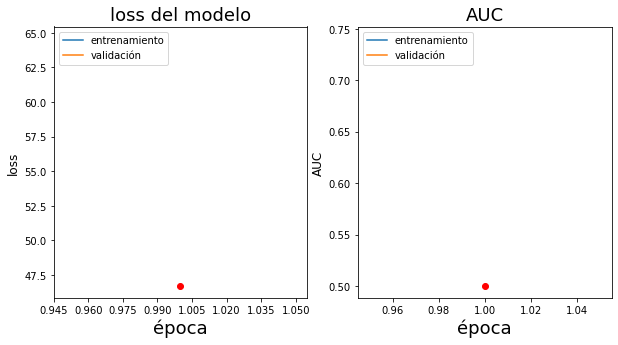

1870/1870 [==============================] - 22s 12ms/sample - loss: 64.5640 - acc: 0.6824 - auc: 0.7403 - val_loss: 46.7150 - val_acc: 0.5132 - val_auc: 0.5000 - lr: 6.5610e-04

Epoch 00005: LearningRateScheduler setting learning rate to 0.0005904900433961303.
Learning rate = 0.00059
Epoch 5/1000
1870/1870 [==============================] - ETA: 0s - loss: 36.0499 - acc: 0.7128 - auc: 0.7756

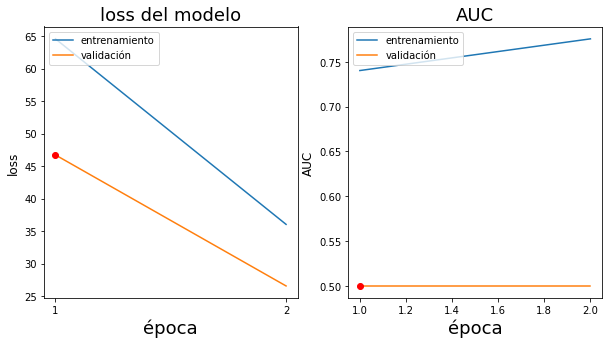

1870/1870 [==============================] - 22s 12ms/sample - loss: 36.0499 - acc: 0.7128 - auc: 0.7756 - val_loss: 26.5826 - val_acc: 0.5132 - val_auc: 0.5000 - lr: 5.9049e-04

Epoch 00006: LearningRateScheduler setting learning rate to 0.0005314410547725857.
Learning rate = 0.00053
Epoch 6/1000
1870/1870 [==============================] - ETA: 0s - loss: 21.0299 - acc: 0.7652 - auc: 0.8212

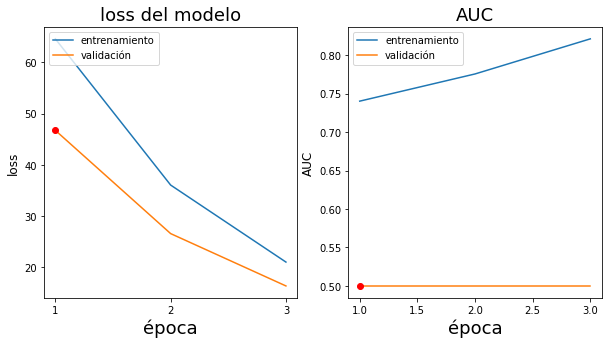

1870/1870 [==============================] - 22s 12ms/sample - loss: 21.0299 - acc: 0.7652 - auc: 0.8212 - val_loss: 16.3737 - val_acc: 0.5132 - val_auc: 0.5000 - lr: 5.3144e-04

Epoch 00007: LearningRateScheduler setting learning rate to 0.00047829695977270604.
Learning rate = 0.00048
Epoch 7/1000
1870/1870 [==============================] - ETA: 0s - loss: 13.3180 - acc: 0.8182 - auc: 0.8808

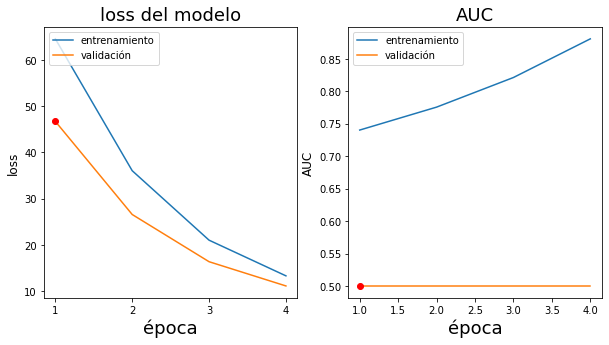

1870/1870 [==============================] - 22s 12ms/sample - loss: 13.3180 - acc: 0.8182 - auc: 0.8808 - val_loss: 11.1344 - val_acc: 0.4868 - val_auc: 0.5000 - lr: 4.7830e-04

Epoch 00008: LearningRateScheduler setting learning rate to 0.0004304672533180565.
Learning rate = 0.00043
Epoch 8/1000
1870/1870 [==============================] - ETA: 0s - loss: 8.9947 - acc: 0.8802 - auc: 0.9281

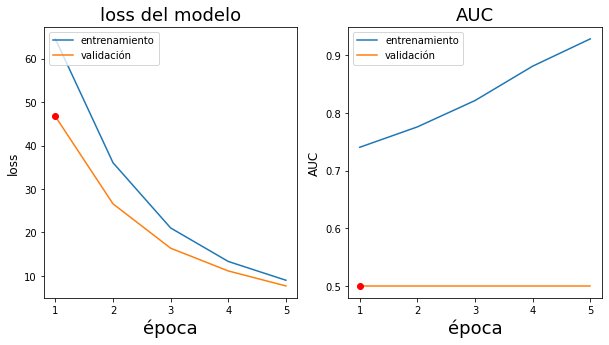

1870/1870 [==============================] - 22s 12ms/sample - loss: 8.9947 - acc: 0.8802 - auc: 0.9281 - val_loss: 7.6836 - val_acc: 0.4868 - val_auc: 0.5000 - lr: 4.3047e-04

Epoch 00009: LearningRateScheduler setting learning rate to 0.00038742052274756136.
Learning rate = 0.00039
Epoch 9/1000
1870/1870 [==============================] - ETA: 0s - loss: 6.1379 - acc: 0.9134 - auc: 0.9606

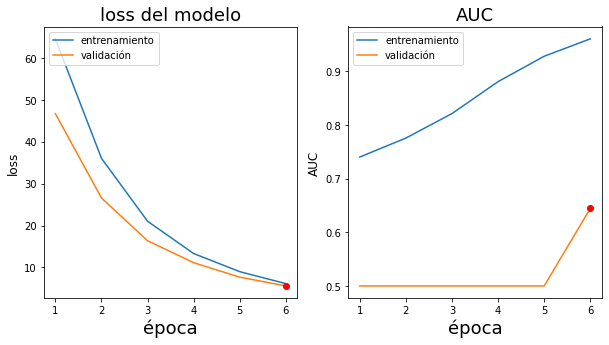

1870/1870 [==============================] - 22s 12ms/sample - loss: 6.1379 - acc: 0.9134 - auc: 0.9606 - val_loss: 5.5891 - val_acc: 0.5132 - val_auc: 0.6445 - lr: 3.8742e-04

Epoch 00010: LearningRateScheduler setting learning rate to 0.0003486784757114947.
Learning rate = 0.00035
Epoch 10/1000
1870/1870 [==============================] - ETA: 0s - loss: 4.3896 - acc: 0.9503 - auc: 0.9766

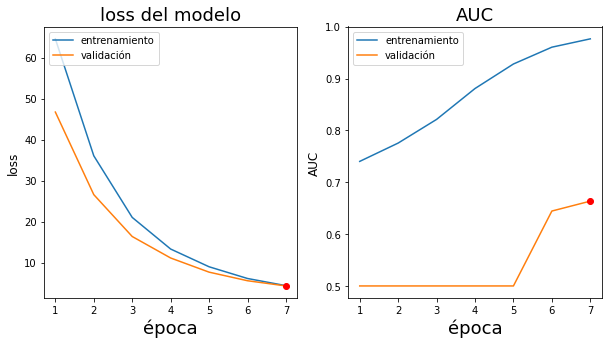

1870/1870 [==============================] - 22s 12ms/sample - loss: 4.3896 - acc: 0.9503 - auc: 0.9766 - val_loss: 4.3191 - val_acc: 0.4868 - val_auc: 0.6636 - lr: 3.4868e-04

Epoch 00011: LearningRateScheduler setting learning rate to 0.00031381062290165574.
Learning rate = 0.00031
Epoch 11/1000
1870/1870 [==============================] - ETA: 0s - loss: 3.3782 - acc: 0.9674 - auc: 0.9832

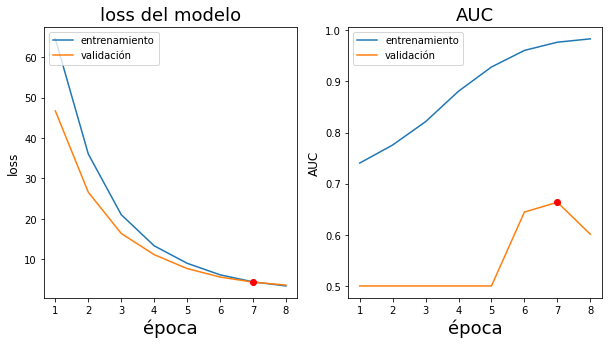

1870/1870 [==============================] - 22s 12ms/sample - loss: 3.3782 - acc: 0.9674 - auc: 0.9832 - val_loss: 3.5902 - val_acc: 0.5474 - val_auc: 0.6012 - lr: 3.1381e-04

Epoch 00012: LearningRateScheduler setting learning rate to 0.0002824295632308349.
Learning rate = 0.00028
Epoch 12/1000
1870/1870 [==============================] - ETA: 0s - loss: 2.7100 - acc: 0.9797 - auc: 0.9888

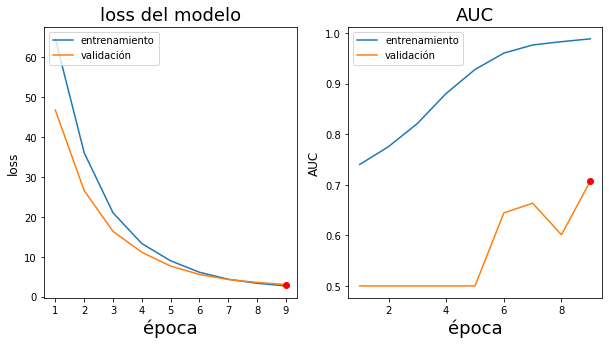

1870/1870 [==============================] - 22s 12ms/sample - loss: 2.7100 - acc: 0.9797 - auc: 0.9888 - val_loss: 3.0418 - val_acc: 0.6079 - val_auc: 0.7073 - lr: 2.8243e-04

Epoch 00013: LearningRateScheduler setting learning rate to 0.00025418660952709616.
Learning rate = 0.00025
Epoch 13/1000
1870/1870 [==============================] - ETA: 0s - loss: 2.2001 - acc: 0.9888 - auc: 0.9909

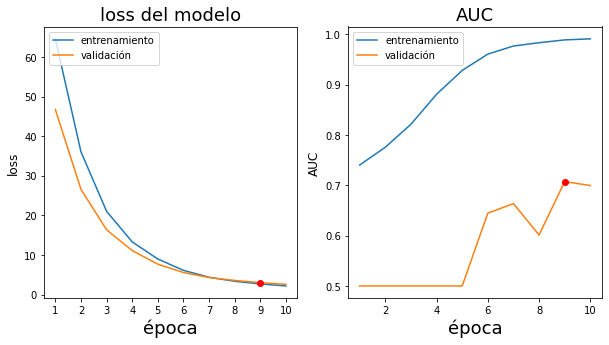

1870/1870 [==============================] - 22s 12ms/sample - loss: 2.2001 - acc: 0.9888 - auc: 0.9909 - val_loss: 2.5968 - val_acc: 0.6500 - val_auc: 0.6995 - lr: 2.5419e-04

Epoch 00014: LearningRateScheduler setting learning rate to 0.00022876793809700757.
Learning rate = 0.00023
Epoch 14/1000
1870/1870 [==============================] - ETA: 0s - loss: 1.8029 - acc: 0.9872 - auc: 0.9922

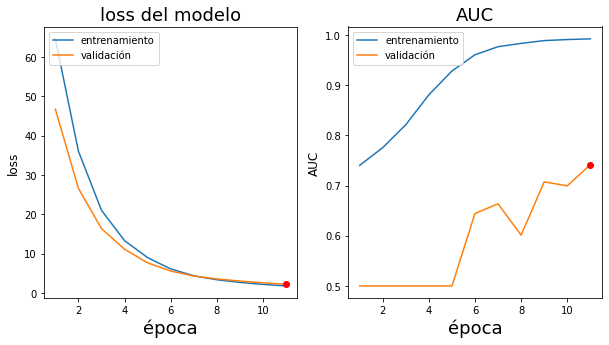

1870/1870 [==============================] - 22s 12ms/sample - loss: 1.8029 - acc: 0.9872 - auc: 0.9922 - val_loss: 2.2396 - val_acc: 0.5868 - val_auc: 0.7414 - lr: 2.2877e-04

Epoch 00015: LearningRateScheduler setting learning rate to 0.00020589114428730683.
Learning rate = 0.00021
Epoch 15/1000
1870/1870 [==============================] - ETA: 0s - loss: 1.5164 - acc: 0.9786 - auc: 0.9900

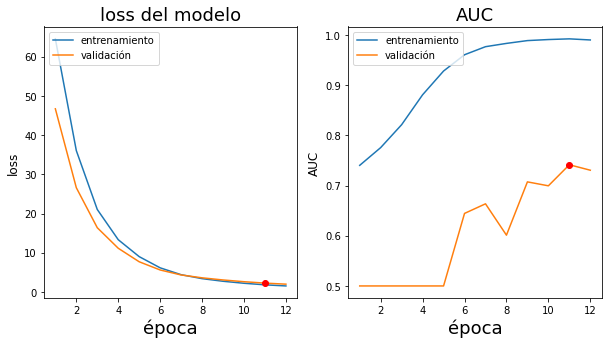

1870/1870 [==============================] - 22s 12ms/sample - loss: 1.5164 - acc: 0.9786 - auc: 0.9900 - val_loss: 1.9703 - val_acc: 0.6658 - val_auc: 0.7305 - lr: 2.0589e-04

Epoch 00016: LearningRateScheduler setting learning rate to 0.00018530203378759326.
Learning rate = 0.00019
Epoch 16/1000
1870/1870 [==============================] - ETA: 0s - loss: 1.2545 - acc: 0.9866 - auc: 0.9919

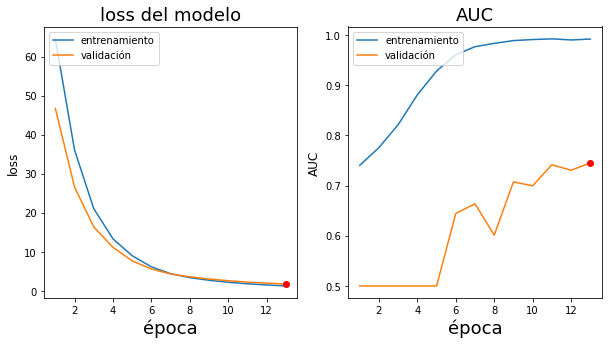

1870/1870 [==============================] - 22s 12ms/sample - loss: 1.2545 - acc: 0.9866 - auc: 0.9919 - val_loss: 1.7384 - val_acc: 0.6711 - val_auc: 0.7449 - lr: 1.8530e-04

Epoch 00017: LearningRateScheduler setting learning rate to 0.00016677183302817866.
Learning rate = 0.00017
Epoch 17/1000
1870/1870 [==============================] - ETA: 0s - loss: 1.0433 - acc: 0.9925 - auc: 0.9931

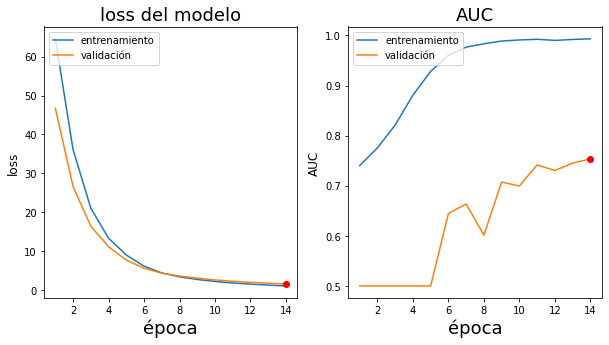

1870/1870 [==============================] - 22s 12ms/sample - loss: 1.0433 - acc: 0.9925 - auc: 0.9931 - val_loss: 1.5515 - val_acc: 0.6842 - val_auc: 0.7537 - lr: 1.6677e-04

Epoch 00018: LearningRateScheduler setting learning rate to 0.00015009464841568844.
Learning rate = 0.00015
Epoch 18/1000
1870/1870 [==============================] - ETA: 0s - loss: 0.8864 - acc: 0.9925 - auc: 0.9931

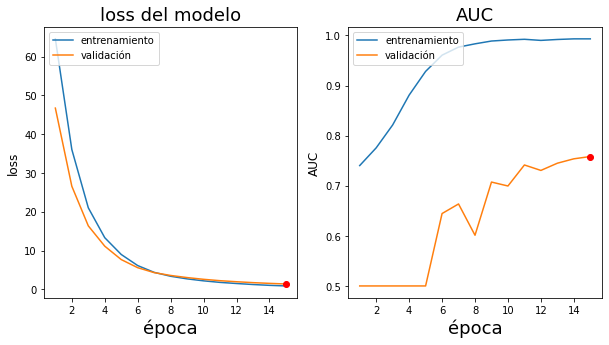

1870/1870 [==============================] - 22s 12ms/sample - loss: 0.8864 - acc: 0.9925 - auc: 0.9931 - val_loss: 1.3934 - val_acc: 0.6895 - val_auc: 0.7583 - lr: 1.5009e-04

Epoch 00019: LearningRateScheduler setting learning rate to 0.0001350851875031367.
Learning rate = 0.00014
Epoch 19/1000
1870/1870 [==============================] - ETA: 0s - loss: 0.7600 - acc: 0.9930 - auc: 0.9940

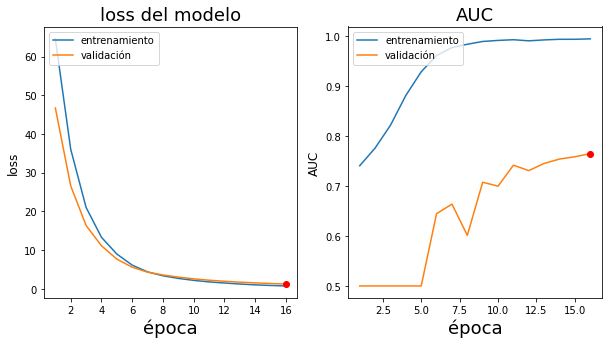

1870/1870 [==============================] - 22s 12ms/sample - loss: 0.7600 - acc: 0.9930 - auc: 0.9940 - val_loss: 1.2647 - val_acc: 0.6895 - val_auc: 0.7645 - lr: 1.3509e-04

Epoch 00020: LearningRateScheduler setting learning rate to 0.00012157666351413355.
Learning rate = 0.00012
Epoch 20/1000
1870/1870 [==============================] - ETA: 0s - loss: 0.6647 - acc: 0.9930 - auc: 0.9932

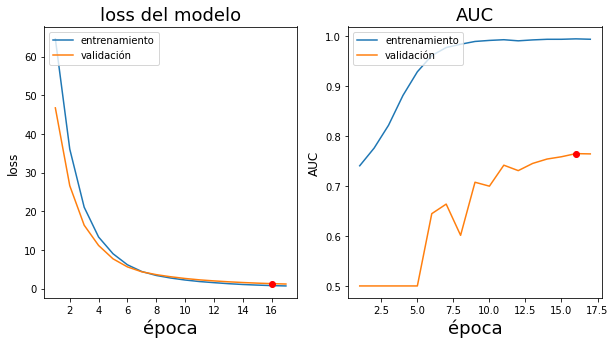

1870/1870 [==============================] - 22s 12ms/sample - loss: 0.6647 - acc: 0.9930 - auc: 0.9932 - val_loss: 1.1623 - val_acc: 0.6947 - val_auc: 0.7640 - lr: 1.2158e-04

Epoch 00021: LearningRateScheduler setting learning rate to 0.00010941899454337544.
Learning rate = 0.00011
Epoch 21/1000
1870/1870 [==============================] - ETA: 0s - loss: 0.5877 - acc: 0.9941 - auc: 0.9934

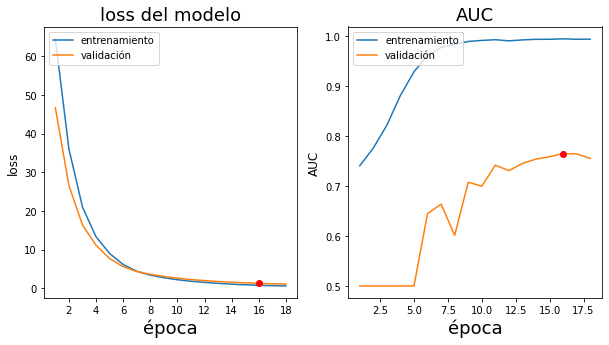

1870/1870 [==============================] - 22s 12ms/sample - loss: 0.5877 - acc: 0.9941 - auc: 0.9934 - val_loss: 1.0807 - val_acc: 0.6789 - val_auc: 0.7548 - lr: 1.0942e-04

Epoch 00022: LearningRateScheduler setting learning rate to 9.847709443420172e-05.
Learning rate = 0.00010
Epoch 22/1000
1870/1870 [==============================] - ETA: 0s - loss: 0.5328 - acc: 0.9920 - auc: 0.9964

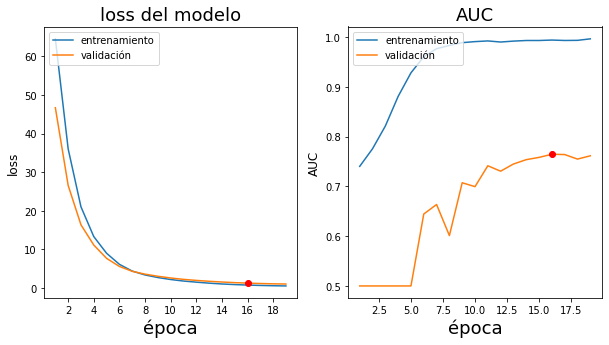

1870/1870 [==============================] - 22s 12ms/sample - loss: 0.5328 - acc: 0.9920 - auc: 0.9964 - val_loss: 1.0291 - val_acc: 0.6789 - val_auc: 0.7614 - lr: 9.8477e-05

Epoch 00023: LearningRateScheduler setting learning rate to 8.862938630045391e-05.
Learning rate = 0.00009
Epoch 23/1000
1870/1870 [==============================] - ETA: 0s - loss: 0.4823 - acc: 0.9925 - auc: 0.9935

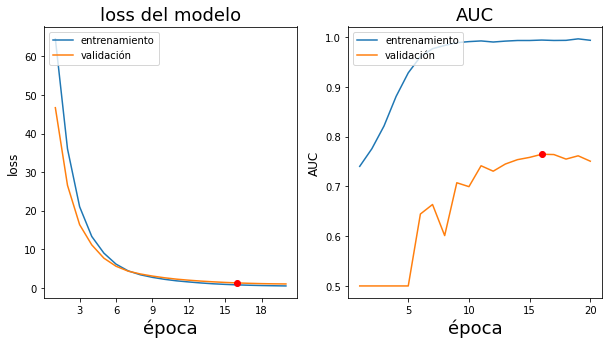

1870/1870 [==============================] - 22s 12ms/sample - loss: 0.4823 - acc: 0.9925 - auc: 0.9935 - val_loss: 0.9988 - val_acc: 0.6895 - val_auc: 0.7506 - lr: 8.8629e-05

Epoch 00024: LearningRateScheduler setting learning rate to 7.976644701557234e-05.
Learning rate = 0.00008
Epoch 24/1000
1870/1870 [==============================] - ETA: 0s - loss: 0.4250 - acc: 0.9952 - auc: 0.9956

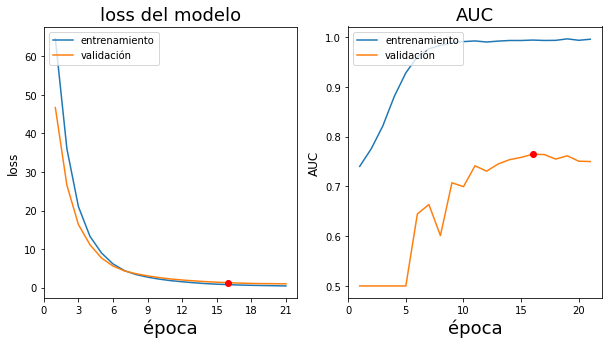

1870/1870 [==============================] - 22s 12ms/sample - loss: 0.4250 - acc: 0.9952 - auc: 0.9956 - val_loss: 0.9762 - val_acc: 0.6868 - val_auc: 0.7499 - lr: 7.9766e-05

Epoch 00025: LearningRateScheduler setting learning rate to 7.178980231401511e-05.
Learning rate = 0.00007
Epoch 25/1000
1870/1870 [==============================] - ETA: 0s - loss: 0.3906 - acc: 0.9952 - auc: 0.9948

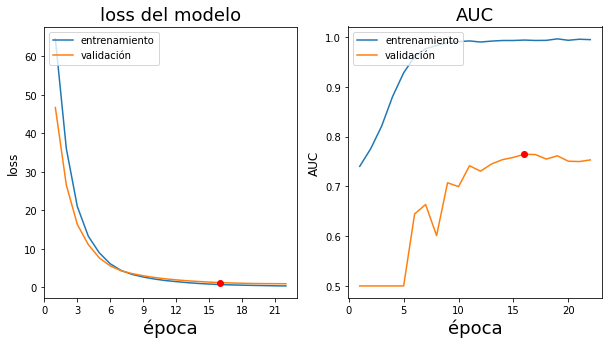

1870/1870 [==============================] - 22s 12ms/sample - loss: 0.3906 - acc: 0.9952 - auc: 0.9948 - val_loss: 0.9681 - val_acc: 0.6895 - val_auc: 0.7532 - lr: 7.1790e-05

Epoch 00026: LearningRateScheduler setting learning rate to 6.461082011810504e-05.
Learning rate = 0.00006
Epoch 26/1000
1870/1870 [==============================] - ETA: 0s - loss: 0.3629 - acc: 0.9952 - auc: 0.9934

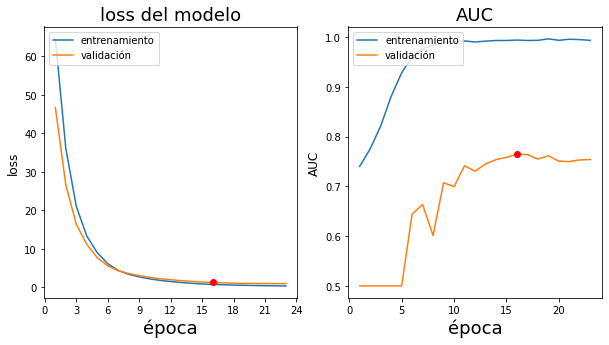

1870/1870 [==============================] - 22s 12ms/sample - loss: 0.3629 - acc: 0.9952 - auc: 0.9934 - val_loss: 0.9646 - val_acc: 0.6895 - val_auc: 0.7540 - lr: 6.4611e-05

Epoch 00027: LearningRateScheduler setting learning rate to 5.8149741380475466e-05.
Learning rate = 0.00006
Epoch 27/1000
1870/1870 [==============================] - ETA: 0s - loss: 0.3432 - acc: 0.9930 - auc: 0.9942

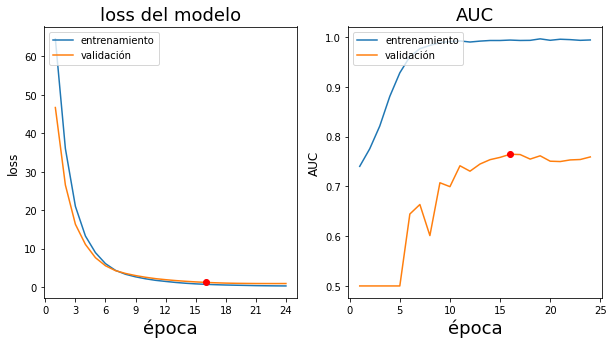

1870/1870 [==============================] - 22s 12ms/sample - loss: 0.3432 - acc: 0.9930 - auc: 0.9942 - val_loss: 0.9730 - val_acc: 0.7026 - val_auc: 0.7592 - lr: 5.8150e-05

Epoch 00028: LearningRateScheduler setting learning rate to 5.233476658759173e-05.
Learning rate = 0.00005
Epoch 28/1000
1870/1870 [==============================] - ETA: 0s - loss: 0.3356 - acc: 0.9920 - auc: 0.9949

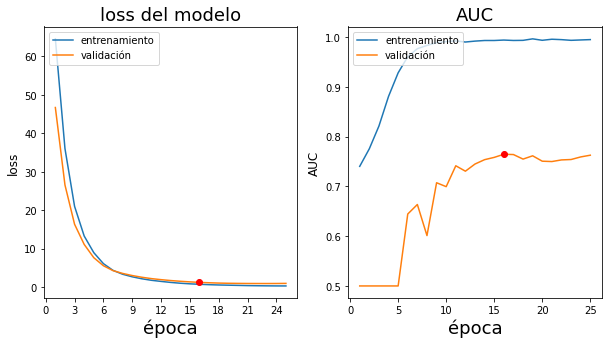

1870/1870 [==============================] - 22s 12ms/sample - loss: 0.3356 - acc: 0.9920 - auc: 0.9949 - val_loss: 0.9983 - val_acc: 0.7237 - val_auc: 0.7627 - lr: 5.2335e-05

Epoch 00029: LearningRateScheduler setting learning rate to 4.7101289601414466e-05.
Learning rate = 0.00005
Epoch 29/1000
1870/1870 [==============================] - ETA: 0s - loss: 0.2998 - acc: 0.9952 - auc: 0.9959Restoring model weights from the end of the best epoch: 19.


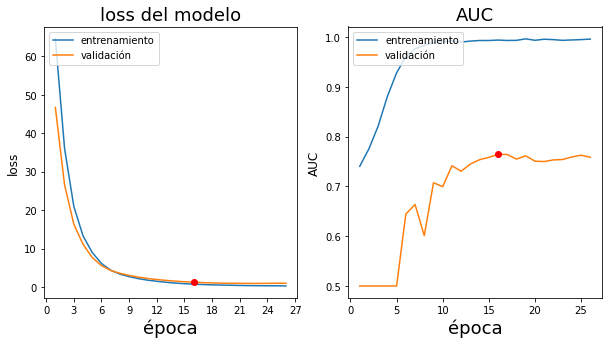

1870/1870 [==============================] - 31s 17ms/sample - loss: 0.2998 - acc: 0.9952 - auc: 0.9959 - val_loss: 0.9918 - val_acc: 0.7132 - val_auc: 0.7585 - lr: 4.7101e-05
Epoch 00029: early stopping


In [76]:
###### ENTRENAMIENTO
model.fit(x = [tab_X_train, X_train], 
                    y = y_train,
                    validation_data=([tab_X_val, X_val], y_val),
                    batch_size=batch_size, 
                    epochs=epochs,
                    class_weight=class_weights,
                    callbacks = callbacks_list,       
                    verbose=1)

### Predict

In [78]:
pred_train = model.predict([tab_X_train,X_train])
pred_val = model.predict([tab_X_val,X_val])
pred_test = model.predict([tab_X_test,X_test])

/home/iexpress/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


### Metrics

In [79]:
auc_train = roc_auc_score(y_true = y_train, y_score = pred_train)
auc_val = roc_auc_score(y_true = y_val, y_score = pred_val)
auc_test = roc_auc_score(y_true = y_test, y_score = pred_test)
print('AUC train = %s - AUC val = %s - AUC test = %s' % (str(auc_train), str(auc_val), str(auc_test)))

AUC train = 0.9928730328746806 - AUC val = 0.7685100485100484 - AUC test = 0.681905622992132


In [23]:
y_labels_train = (pred_train >= 0.5).astype(int)
y_labels_val = (pred_val >= 0.5).astype(int)
y_labels_test = (pred_test >= 0.5).astype(int)
cm_train = confusion_matrix(y_pred = y_labels_train, y_true = y_train)
cm_val = confusion_matrix(y_pred = y_labels_val, y_true = y_val)
cm_test = confusion_matrix(y_pred = y_labels_test, y_true = y_test)
print(cm_train)
print(cm_val)
print(cm_test)

[[873  81]
 [209 707]]
[[154  41]
 [ 55 130]]
[[186  43]
 [ 64 163]]


### Save output

In [24]:
np.savetxt(os.path.join(save_dir, 'predictions', 'predictions_train_mixed.csv'), pred_train, delimiter=";")
np.savetxt(os.path.join(save_dir, 'predictions', 'predictions_val_mixed.csv'), pred_val, delimiter=";")
np.savetxt(os.path.join(save_dir, 'predictions','predictions_test_mixed.csv'),pred_test, delimiter=";")

## Heatmap / Gradcam

In [80]:
tf.compat.v1.disable_eager_execution()

index 0


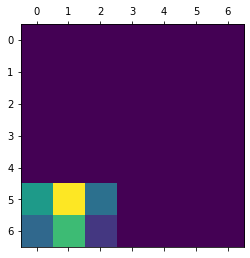

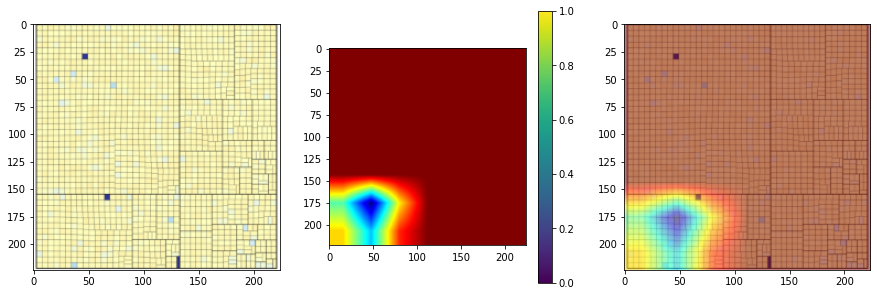

- Probabilidad de Exitus: 0.6348716
- Clase real: No sobrevive




index 1


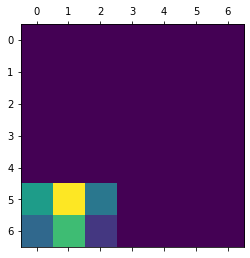

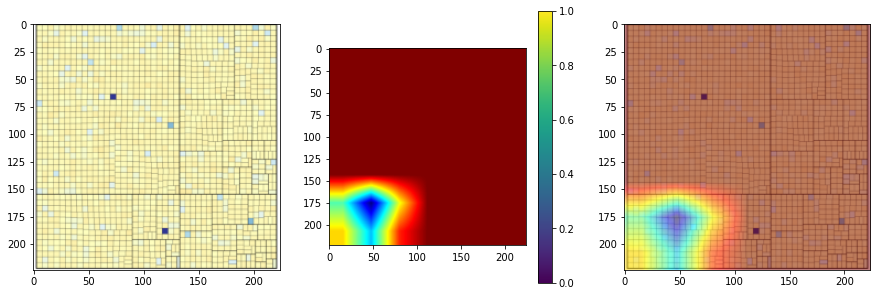

- Probabilidad de Exitus: 0.6348697
- Clase real: No sobrevive




index 2


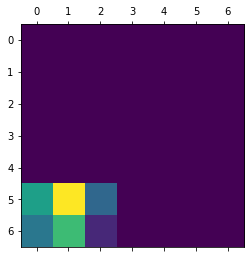

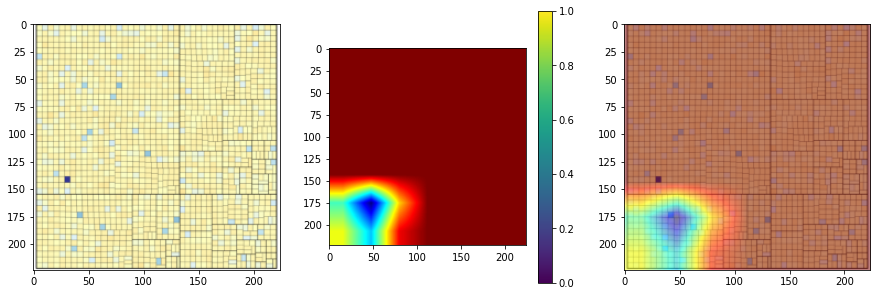

- Probabilidad de Exitus: 0.634869
- Clase real: No sobrevive




index 3


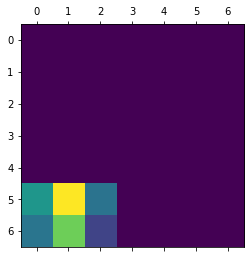

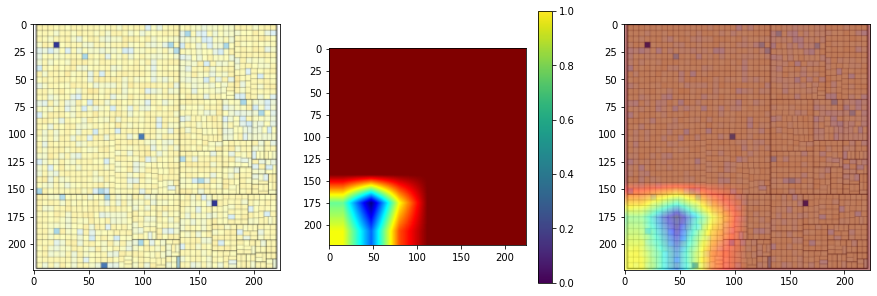

- Probabilidad de Exitus: 0.6348711
- Clase real: No sobrevive




index 4


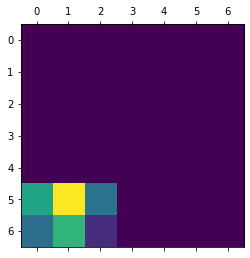

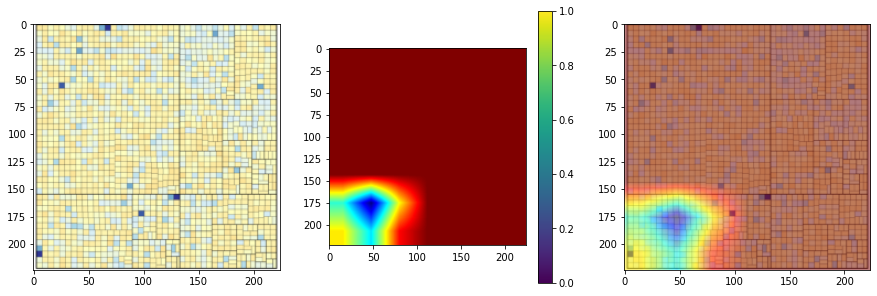

- Probabilidad de Exitus: 0.6348717
- Clase real: No sobrevive




index 5


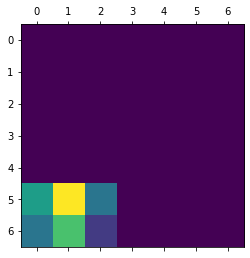

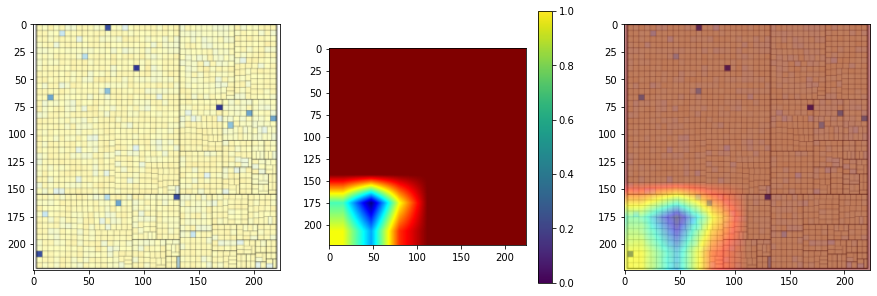

- Probabilidad de Exitus: 0.6348719
- Clase real: No sobrevive




index 6


KeyboardInterrupt: 

In [81]:
for i in np.where(y_test == 1)[0]:
    print('index ' + str(i));
    heat_map, superimposed_img = show_heatmap(model, X_test[i], y_test.iloc[i], pred_test[i])